# Recurrent Neural Network - Basic RNN

Recurrent Neural Networks (RNN) are very effective for Natural Language Processing and other sequence tasks because they have **memory**. They can read inputs $x^{\langle t \rangle}$ (such as words) one at a time, and remember some information/context through the hidden layer activations that get passed from one time-step to the next. This allows a uni-directional RNN to take information from the past to process later inputs. A bidirection RNN can take context from both the past and the future. 

**Notation**:
- Superscript $[l]$ denotes an object associated with the $l^{th}$ layer. 
    - Example: $a^{[4]}$ is the $4^{th}$ layer activation. $W^{[5]}$ and $b^{[5]}$ are the $5^{th}$ layer parameters.

- Superscript $(i)$ denotes an object associated with the $i^{th}$ example. 
    - Example: $x^{(i)}$ is the $i^{th}$ training example input.

- Superscript $\langle t \rangle$ denotes an object at the $t^{th}$ time-step. 
    - Example: $x^{\langle t \rangle}$ is the input x at the $t^{th}$ time-step. $x^{(i)\langle t \rangle}$ is the input at the $t^{th}$ timestep of example $i$.
    
- Lowerscript $i$ denotes the $i^{th}$ entry of a vector.
    - Example: $a^{[l]}_i$ denotes the $i^{th}$ entry of the activations in layer $l$.


```python
import numpy as np
```

# Helper functions

```python
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

```

# Forward propagation for the basic Recurrent Neural Network

The basic RNN that you will implement has the structure below. In this example, $T_x = T_y$. 

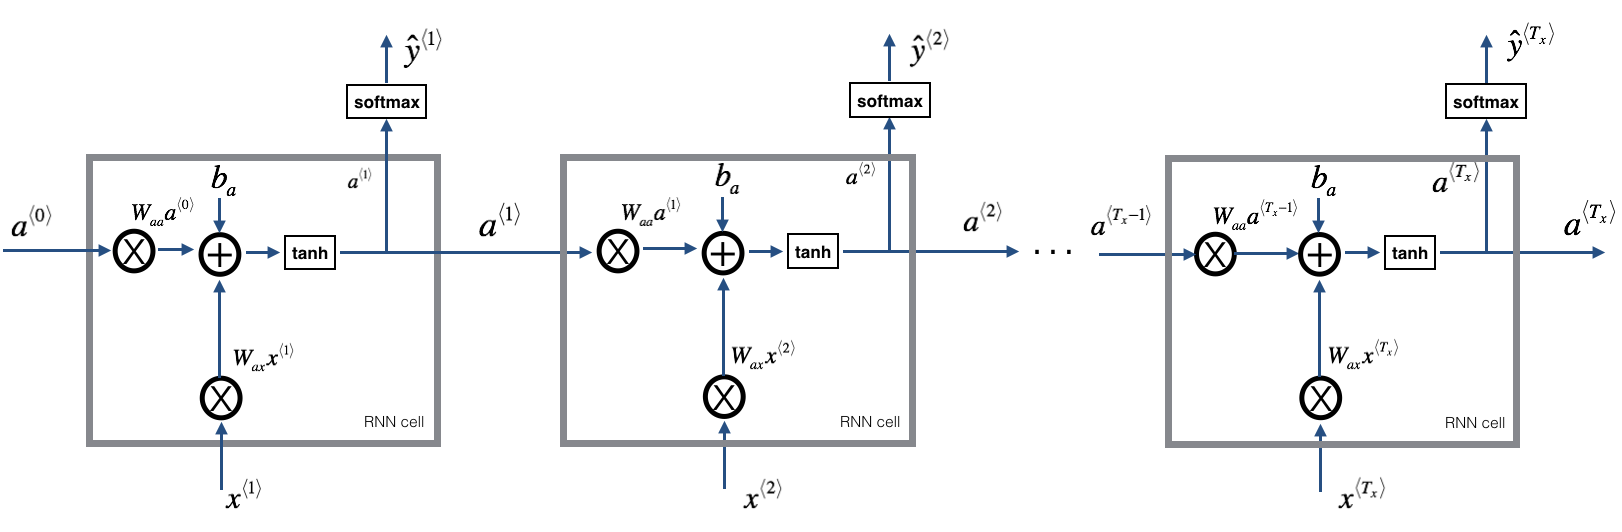

Here's how you can implement an RNN: 

**Steps**:
1. Implement the calculations needed for one time-step of the RNN.
2. Implement a loop over $T_x$ time-steps in order to process all the inputs, one at a time. 

## RNN cell

A Recurrent neural network can be seen as the repetition of a single cell. You are first going to implement the computations for a single time-step. The following figure describes the operations for a single time-step of an RNN cell. 


Basic RNN cell. Takes as input $x^{\langle t \rangle}$ (current input) and $a^{\langle t - 1\rangle}$ (previous hidden state containing information from the past), and outputs $a^{\langle t \rangle}$ which is given to the next RNN cell and also used to predict $y^{\langle t \rangle}$ 


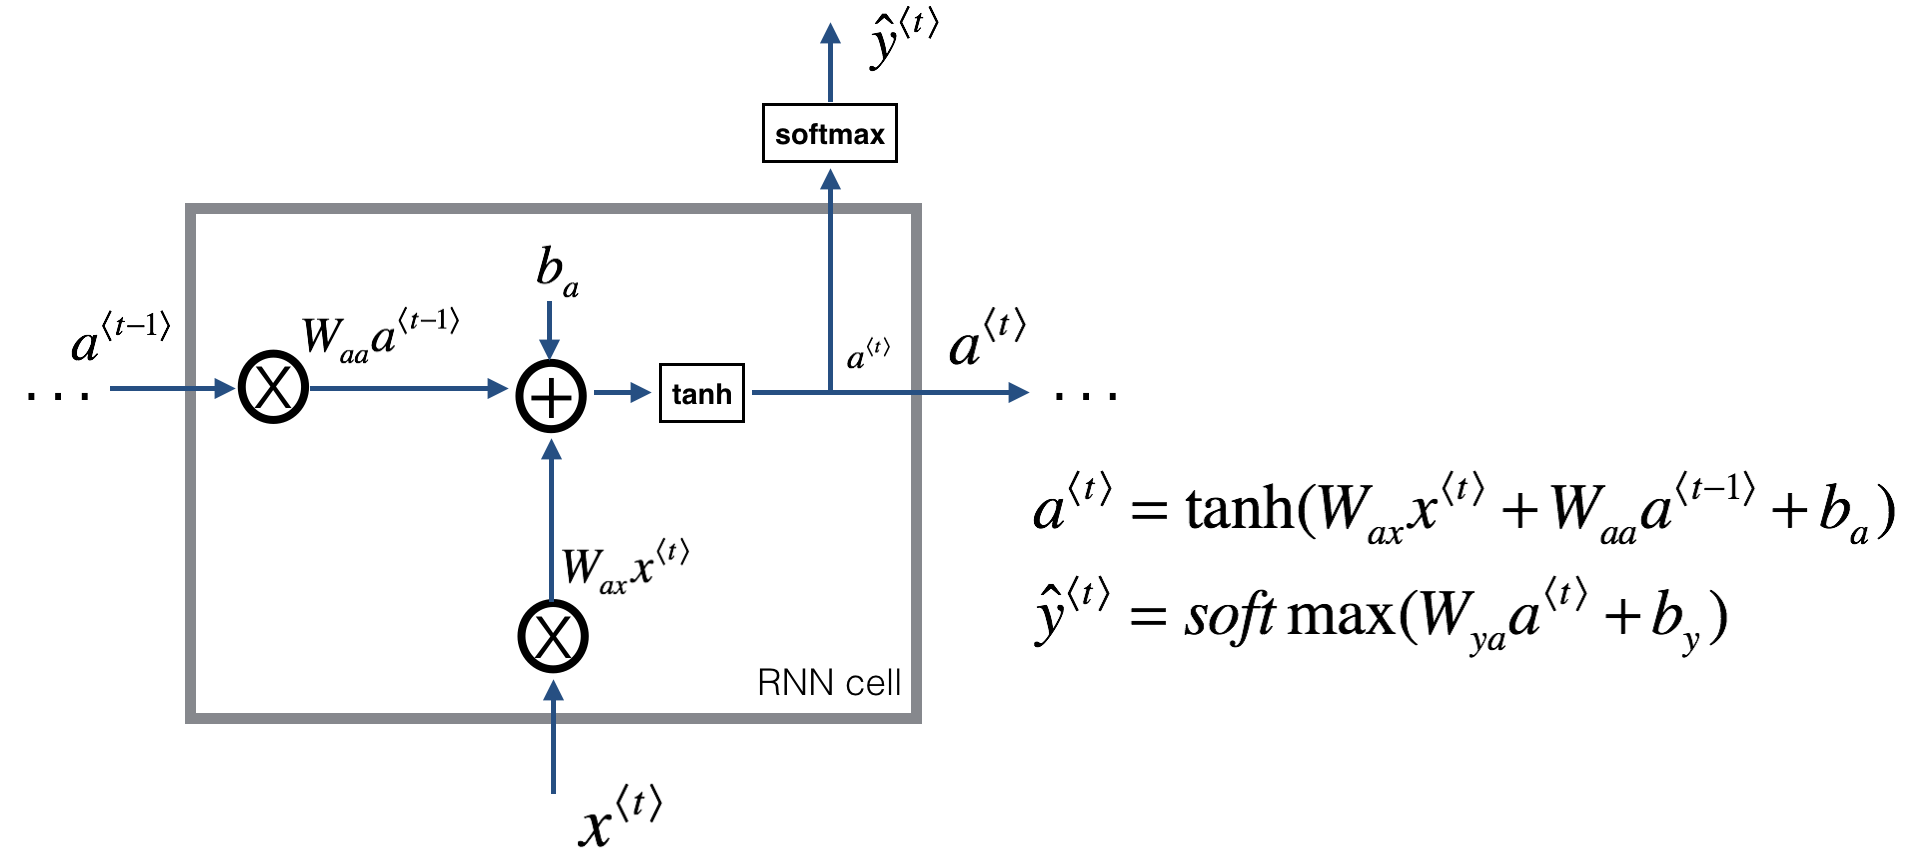

**Implementing the RNN-cell**:
1. Compute the hidden state with tanh activation: $a^{\langle t \rangle} = \tanh(W_{aa} a^{\langle t-1 \rangle} + W_{ax} x^{\langle t \rangle} + b_a)$.
2. Using your new hidden state $a^{\langle t \rangle}$, compute the prediction $\hat{y}^{\langle t \rangle} = softmax(W_{ya} a^{\langle t \rangle} + b_y)$. We provided you a function: `softmax`.
3. Store $(a^{\langle t \rangle}, a^{\langle t-1 \rangle}, x^{\langle t \rangle}, parameters)$ in cache
4. Return $a^{\langle t \rangle}$ , $y^{\langle t \rangle}$ and cache

We will vectorize over $m$ examples. Thus, $x^{\langle t \rangle}$ will have dimension $(n_x,m)$, and $a^{\langle t \rangle}$ will have dimension $(n_a,m)$. 

 """
 
    Implements a single forward step of the RNN-cell as described in Figure (2)

    Arguments:
    xt -- your input data at timestep "t", numpy array of shape (n_x, m).
    a_prev -- Hidden state at timestep "t-1", numpy array of shape (n_a, m)
    parameters -- python dictionary containing:
                        Wax -- Weight matrix multiplying the input, numpy array of shape (n_a, n_x)
                        Waa -- Weight matrix multiplying the hidden state, numpy array of shape (n_a, n_a)
                        Wya -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
                        ba --  Bias, numpy array of shape (n_a, 1)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)
    Returns:
    a_next -- next hidden state, of shape (n_a, m)
    yt_pred -- prediction at timestep "t", numpy array of shape (n_y, m)
    cache -- tuple of values needed for the backward pass, contains (a_next, a_prev, xt, parameters)
    """

```python
def rnn_cell_forward(xt, a_prev, parameters):    
    # Retrieve parameters from "parameters"
    Waa, Wax, Wya, by, ba = parameters['Waa'], parameters['Wax'], parameters['Wya'], parameters['by'], parameters['ba']
      
    # compute next activation state using the formula given above
    a_next = np.tanh(np.dot(Waa, a_prev) + np.dot(Wax, xt) + ba)
    
    # compute output of the current cell using the formula given above
    yt_pred = softmax(np.dot(Wya, a_next) + by)
    
    # store values you need for backward propagation in cache
    cache = (a_next, a_prev, xt, parameters)
    
    return a_next, yt_pred, cache

def rnn_step_forward(parameters, a_prev, x):
    
    Waa, Wax, Wya, by, b = parameters['Waa'], parameters['Wax'], parameters['Wya'], parameters['by'], parameters['b']
    a_next = np.tanh(np.dot(Wax, x) + np.dot(Waa, a_prev) + b) # hidden state
    p_t = softmax(np.dot(Wya, a_next) + by) # unnormalized log probabilities for next chars # probabilities for next chars 
    
    return a_next, p_t
```

# RNN forward pass 

You can see an RNN as the repetition of the cell you've just built. If your input sequence of data is carried over 10 time steps, then you will copy the RNN cell 10 times. Each cell takes as input the hidden state from the previous cell ($a^{\langle t-1 \rangle}$) and the current time-step's input data ($x^{\langle t \rangle}$). It outputs a hidden state ($a^{\langle t \rangle}$) and a prediction ($y^{\langle t \rangle}$) for this time-step.

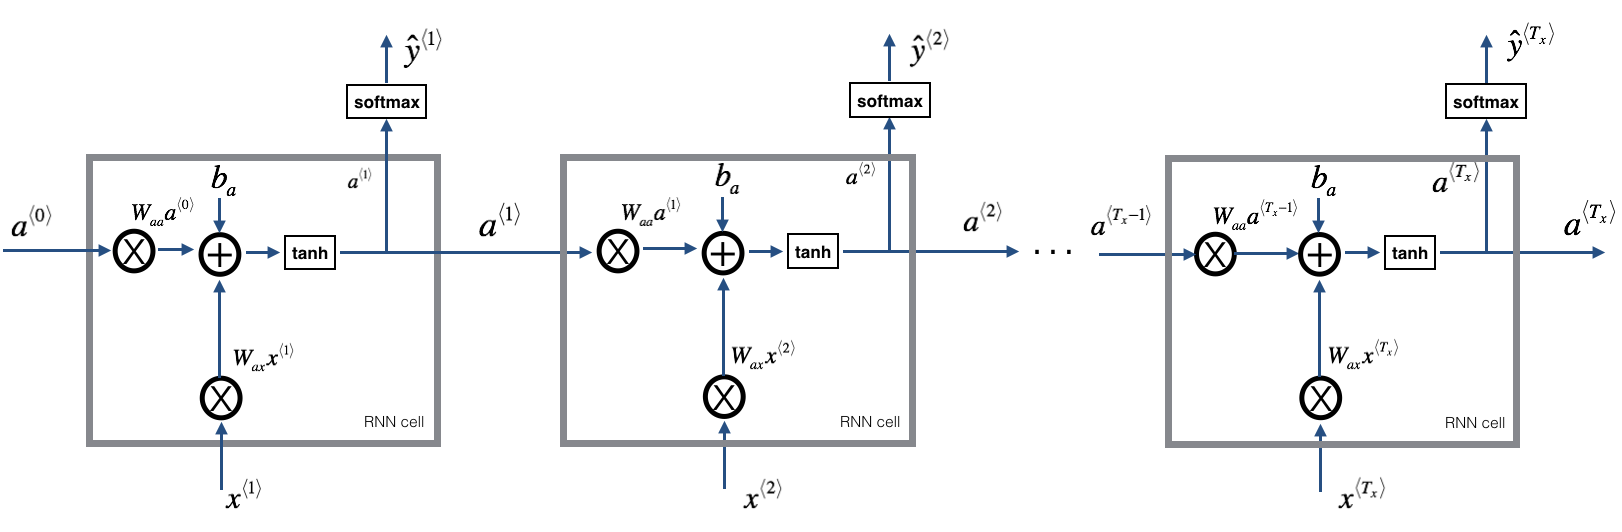





**forward propagation of the RNN described in Figure (3).**

**Instructions**:
1. Create a vector of zeros ($a$) that will store all the hidden states computed by the RNN.
2. Initialize the "next" hidden state as $a_0$ (initial hidden state).
3. Start looping over each time step, your incremental index is $t$ :
    - Update the "next" hidden state and the cache by running `rnn_cell_forward`
    - Store the "next" hidden state in $a$ ($t^{th}$ position) 
    - Store the prediction in y
    - Add the cache to the list of caches
4. Return $a$, $y$ and caches

"""

    Implement the forward propagation of the recurrent neural network described in Figure (3).

    Arguments:
    x -- Input data for every time-step, of shape (n_x, m, T_x).
    a0 -- Initial hidden state, of shape (n_a, m)
    parameters -- python dictionary containing:
                        Waa -- Weight matrix multiplying the hidden state, numpy array of shape (n_a, n_a)
                        Wax -- Weight matrix multiplying the input, numpy array of shape (n_a, n_x)
                        Wya -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
                        ba --  Bias numpy array of shape (n_a, 1)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)

    Returns:
    a -- Hidden states for every time-step, numpy array of shape (n_a, m, T_x)
    y_pred -- Predictions for every time-step, numpy array of shape (n_y, m, T_x)
    caches -- tuple of values needed for the backward pass, contains (list of caches, x)
    """

```python
def rnn_forward(x, a0, parameters):
    
    # Initialize "caches" which will contain the list of all caches
    caches = []
    
    # Retrieve dimensions from shapes of x and Wy
    n_x, m, T_x = x.shape
    n_y, n_a = parameters["Wya"].shape
     
    # initialize "a" and "y" with zeros (≈2 lines)
    a = np.zeros((n_a, m, T_x))
    y_pred = np.zeros((n_y, m, T_x))
    
    # Initialize a_next (≈1 line)
    a_next = a0
    
    # loop over all time-steps
    for t in range(T_x):
        # Update next hidden state, compute the prediction, get the cache (≈1 line)
        a_next, yt_pred, cache = rnn_cell_forward(x[:,:,t], a_next, parameters)
        # Save the value of the new "next" hidden state in a (≈1 line)
        a[:,:,t] = a_next
        # Save the value of the prediction in y (≈1 line)
        y_pred[:,:,t] = yt_pred
        # Append "cache" to "caches" (≈1 line)
        caches.append(cache)
        
    # store values needed for backward propagation in cache
    caches = (caches, x)
    
    return a, y_pred, caches
```

Now we have built the forward propagation of a recurrent neural network from scratch but it suffers from vanishing gradient problems. So it works best when each output $y^{\langle t \rangle}$ can be estimated using mainly "local" context (meaning information from inputs $x^{\langle t' \rangle}$ where $t'$ is not too far from $t$). 



We now have the forward passes for the basic RNN. When using a deep learning framework, implementing the forward pass is sufficient to build systems that achieve great performance. 


# Backpropagation in recurrent neural networks

In modern deep learning frameworks, you only have to implement the forward pass, and the framework takes care of the backward pass, so most deep learning engineers do not need to bother with the details of the backward pass. If however you are an expert in calculus and want to see the details of backprop in RNNs, you can work through this optional portion of the notebook. 

In recurrent neural networks you can to calculate the derivatives with respect to the cost in order to update the parameters. The backprop equations are quite complicated and we did not derive them in lecture. However, we will briefly present them below. 

# Basic RNN  backward pass

Computing the backward pass for the basic RNN-cell.

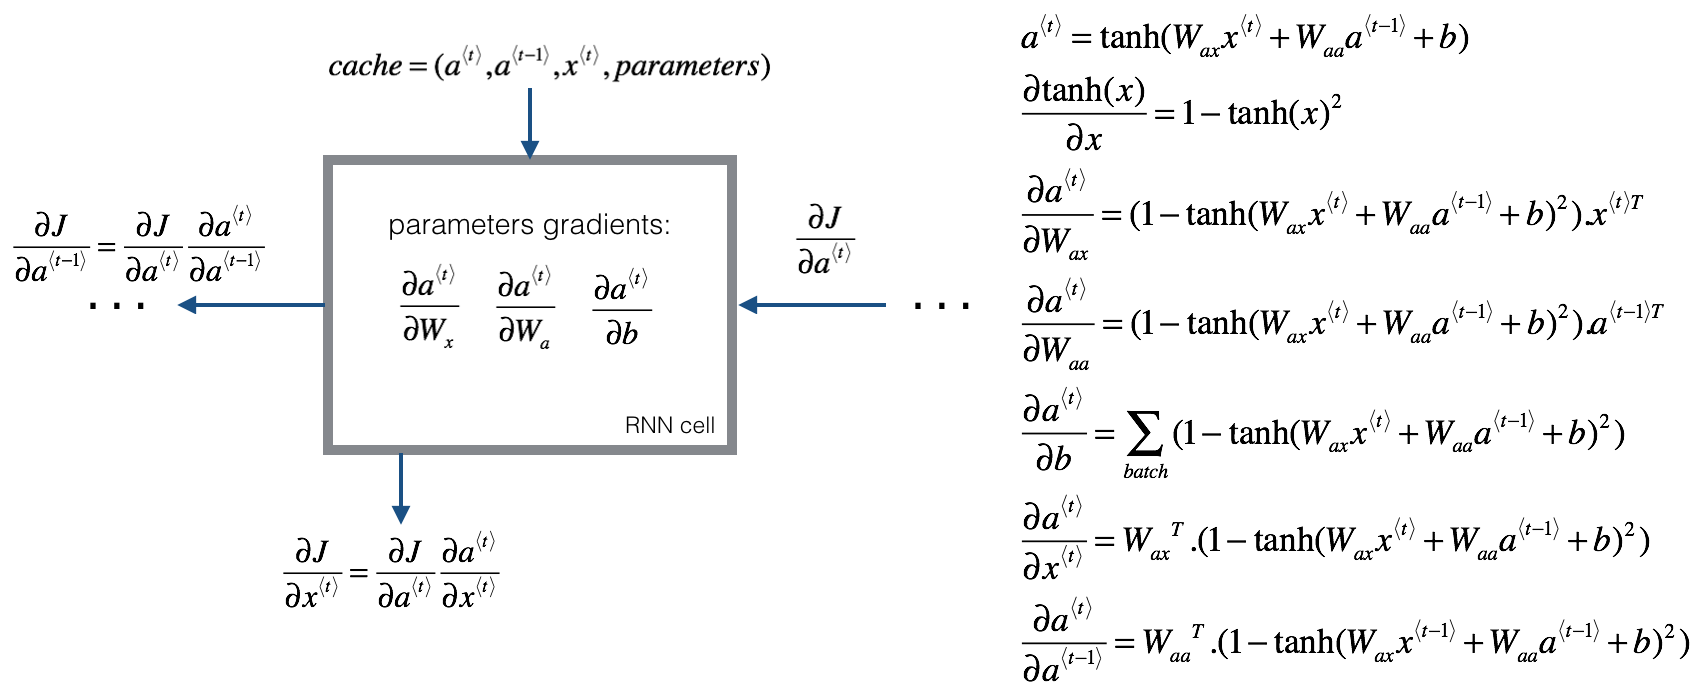

RNN-cell's backward pass. Just like in a fully-connected neural network, the derivative of the cost function $J$ backpropagates through the RNN by following the chain-rule from calculas. The chain-rule is also used to calculate $(\frac{\partial J}{\partial W_{ax}},\frac{\partial J}{\partial W_{aa}},\frac{\partial J}{\partial b})$ to update the parameters $(W_{ax}, W_{aa}, b_a)$.

#### Deriving the one step backward functions: 

To compute the `rnn_cell_backward` you need to compute the following equations. It is a good exercise to derive them by hand. 

The derivative of $\tanh$ is $1-\tanh(x)^2$. You can find the complete proof [here](https://www.wyzant.com/resources/lessons/math/calculus/derivative_proofs/tanx). Note that: $ \sec(x)^2 = 1 - \tanh(x)^2$

Similarly for $\frac{ \partial a^{\langle t \rangle} } {\partial W_{ax}}, \frac{ \partial a^{\langle t \rangle} } {\partial W_{aa}},  \frac{ \partial a^{\langle t \rangle} } {\partial b}$, the derivative of  $\tanh(u)$ is $(1-\tanh(u)^2)du$. 

The final two equations also follow same rule and are derived using the $\tanh$ derivative. Note that the arrangement is done in a way to get the same dimensions to match.




    """
    Implements the backward pass for the RNN-cell (single time-step).

    Arguments:
    da_next -- Gradient of loss with respect to next hidden state
    cache -- python dictionary containing useful values (output of rnn_cell_forward())

    Returns:
    gradients -- python dictionary containing:
                        dx -- Gradients of input data, of shape (n_x, m)
                        da_prev -- Gradients of previous hidden state, of shape (n_a, m)
                        dWax -- Gradients of input-to-hidden weights, of shape (n_a, n_x)
                        dWaa -- Gradients of hidden-to-hidden weights, of shape (n_a, n_a)
                        dba -- Gradients of bias vector, of shape (n_a, 1)
    """

```python
def rnn_cell_backward(da_next, cache):

    
    # Retrieve values from cache
    (a_next, a_prev, xt, parameters) = cache
    
    # Retrieve values from parameters
    Wax = parameters["Wax"]
    Waa = parameters["Waa"]
    Wya = parameters["Wya"]
    ba = parameters["ba"]
    by = parameters["by"]

    # compute the gradient of tanh with respect to a_next (≈1 line)
    dtanh = (1- a_next**2) * da_next

    # compute the gradient of the loss with respect to Wax (≈2 lines)
    dxt = np.dot(Wax.T, dtanh)
    dWax = np.dot(dtanh, xt.T)

    # compute the gradient with respect to Waa (≈2 lines)
    da_prev = np.dot(Waa.T, dtanh)
    dWaa = np.dot(dtanh, a_prev.T)

    # compute the gradient with respect to b (≈1 line)
    dba = np.sum(dtanh, 1, keepdims=True)

     
    # Store the gradients in a python dictionary
    gradients = {"dxt": dxt, "da_prev": da_prev, "dWax": dWax, "dWaa": dWaa, "dba": dba}
    
    return gradients
```

# Backward pass through the RNN

Computing the gradients of the cost with respect to $a^{\langle t \rangle}$ at every time-step $t$ is useful because it is what helps the gradient backpropagate to the previous RNN-cell. To do so, you need to iterate through all the time steps starting at the end, and at each step, you increment the overall $db_a$, $dW_{aa}$, $dW_{ax}$ and you store $dx$.



Implementing the `rnn_backward` function. Initialize the return variables with zeros first and then loop through all the time steps while calling the `rnn_cell_backward` at each time timestep, update the other variables accordingly.

    """
    Implement the backward pass for a RNN over an entire sequence of input data.

    Arguments:
    da -- Upstream gradients of all hidden states, of shape (n_a, m, T_x)
    caches -- tuple containing information from the forward pass (rnn_forward)
    
    Returns:
    gradients -- python dictionary containing:
                        dx -- Gradient w.r.t. the input data, numpy-array of shape (n_x, m, T_x)
                        da0 -- Gradient w.r.t the initial hidden state, numpy-array of shape (n_a, m)
                        dWax -- Gradient w.r.t the input's weight matrix, numpy-array of shape (n_a, n_x)
                        dWaa -- Gradient w.r.t the hidden state's weight matrix, numpy-arrayof shape (n_a, n_a)
                        dba -- Gradient w.r.t the bias, of shape (n_a, 1)
    """


```python
def rnn_backward(da, caches):
            
    # Retrieve values from the first cache (t=1) of caches (≈2 lines)
    (caches, x) = caches
    (a1, a0, x1, parameters) = caches[0]
    
    # Retrieve dimensions from da's and x1's shapes (≈2 lines)
    n_a, m, T_x = da.shape
    n_x, m = x1.shape
    
    # initialize the gradients with the right sizes (≈6 lines)
    dx = np.zeros((n_x, m, T_x))
    dWax = np.zeros((n_a, n_x))
    dWaa = np.zeros((n_a, n_a))
    dba = np.zeros((n_a, 1))
    da0 = np.zeros((n_a, m))
    da_prevt = np.zeros((n_a, m))
    
    # Loop through all the time steps
    for t in reversed(range(T_x)):
        # Compute gradients at time step t. Choose wisely the "da_next" and the "cache" to 
        #use in the backward propagation step. 
        gradients = rnn_cell_backward(da[:,:, t] + da_prevt, caches[t])
        # Retrieve derivatives from gradients 
        dxt, da_prevt, dWaxt, dWaat, dbat = gradients["dxt"], gradients["da_prev"], 
        gradients["dWax"], gradients["dWaa"], gradients["dba"]
        # Increment global derivatives w.r.t parameters by adding their derivative at time-step t 
        dx[:, :, t] = dxt
        dWax += dWaxt
        dWaa += dWaat
        dba += dbat
        
    # Set da0 to the gradient of a which has been backpropagated through all time-steps 
    da0 = da_prevt
 
    # Store the gradients in a python dictionary
    gradients = {"dx": dx, "da0": da0, "dWax": dWax, "dWaa": dWaa,"dba": dba}
    
    return gradients
```